# Adversarial Variational Bayes toy example
[Ben Poole](http://cs.stanford.edu/~poole)<br/>
January 26, 2017 <br/>

This notebook implements the toy example from:<br/>
[Adversarial Variational Bayes: Unifying Variational Autoencoders and Generative Adversarial Networks](https://arxiv.org/abs/1701.04722)<br/>
Lars Mescheder, Sebastian Nowozin, Andreas Geiger

See this [blog post](http://www.inference.vc/variational-inference-with-implicit-models-part-ii-amortised-inference-2/) for another derivaiton and implementation of this approach. 

## Variational inference
Given samples $x$ from an unobserved data density $q(x)$, we are interested in building a latent-variable generative model $p(x, z)$ such that $p(x)$ is close to $q(x)$. This is a difficult problem as evaluating the density under the model, $p(x)$ requires evaluating an intractable integral over the unobserved latent variable $z$: $p(x)=\int \text{d}z \;p(x, z)$.

Variational inference bypasses this problem by optimizing a lower bound on the log-likelihood of the data:
$$\log p(x) \ge -\text{KL}\left(q(z|x) \| p(z)\right) + \mathbb{E}_{q(z|x)}\left[\log p(x|z)\right]$$
This lower bound depends on an additional distribution, $q(z|x)$ which is known as the _variational distribution_ and acts as an approximation to the true posterior $p(z|x)$. 
To evaluate and learn using the variational lower bound, we need to be able to draw samples from the _variational distribution_ and to evaluate the density of a sample from the _variational distribution_. This typically restricts the family of variational distributions to those with known or tractable densities (e.g. factorial Gaussian, normalizing flows).

## Variational inference with intractable densities
For many models we care about, such as models that exhibit [explaining away](http://www.inference.vc/variational-inference-with-implicit-models-part-ii-amortised-inference-2/), the true posterior distribution is complex and multimodal. Appropriately training these models with variational inference thus requires a rich variational family. One way of generating such complex variatonal families is to use neural networks! Here we will use an implicit posterior to generate samples $z=z_\phi(x, \epsilon$) where $\epsilon \sim \mathcal{N}(0, I)$ and $x$ is the observed data. If $z_\phi$ is a complex neural network, then we can use it to draw samples from any distribution. However, we no longer know how to evaluate the density of $z$, $q(z|x)$ and thus can't compute the $\text{KL}(q(z|x) \| p(z))$ term in the variational lower bound.

The approach taken by adversarial variational bayes is to introduce a discriminator that can approximate the intractable $\text{KL}$ term in the variatonal lower bound. This discriminator is trained to classify between samples $(x, z_\text{prior})$ where $z_\text{prior} \sim p(z)$ and $(x, z_\phi(x, \epsilon))$ where $z_\phi$ is our neural network that approximates the posterior. They show that at convergence, the optimal disriminator $T^*(x, z)$ is equal to $\log q(z|x) - \log p(z)$, the missing intractable term needed to compute the $\text{KL}$ term! In practice, we don't have access to the optimal discriminator so we'll plug in our current best estimate, $T(x, z)$.

The objective optimized by the generative model, $p(x, z)$ and inference network, $z_\phi$ is:
$$\underset{p, \phi}{\max} \mathbb{E}_{x\sim q(x)}\left[\mathbb{E}_\epsilon\left[-T(x, z_\phi(x, \epsilon)) + \log p(x\;|\;z_\phi(x, \epsilon)\right]\right]$$
and the discriminator is trained to minimize the normal GAN loss, but using $z$ sampled from the prior or posterior:
$$\underset{T}{\min}\mathbb{E}_{x\sim q(x)}\left[\mathbb{E}_{\epsilon}\left[\log \sigma\left(T(x, z_\phi(x, \epsilon)\right)\right] + 
\mathbb{E}_{z \sim p(z)}\left[\log\left(1 - \sigma\left(T(x, z)\right)\right)\right]\right]
$$

## Implementation details
We trained an AVB model on the dataset of 4 points used in the paper. Each datapoint is a 4-dimensional binary vector with one non-zero component. For all the inference, generative, and discriminator networks we used neural networks with 2 hidden layers of 256 hidden units.

Send questions/comments/bugs to [@poolio](https://twitter.com/poolio).

## Setup

In [ ]:
%pylab inline
import tensorflow as tf
slim = tf.contrib.slim
ds = tf.contrib.distributions
st = tf.contrib.bayesflow.stochastic_tensor
graph_replace = tf.contrib.graph_editor.graph_replace

## Parameters

In [2]:
params = {
    'batch_size': 512,
    'latent_dim': 2, # dimensionality of latent space
    'eps_dim': 4, # dimensionality of epsilon, used in inference net, z_phi(x, eps)
    'input_dim': 4, # dimensionality of input (also the number of unique datapoints)
    'n_layer_disc': 2, # number of hidden layers in discriminator
    'n_hidden_disc': 256, # number of hidden units in discriminator
    'n_layer_gen': 2,
    'n_hidden_gen': 256,
    'n_layer_inf': 2,
    'n_hidden_inf': 256,
}

## Create dataset of one-hot vectors

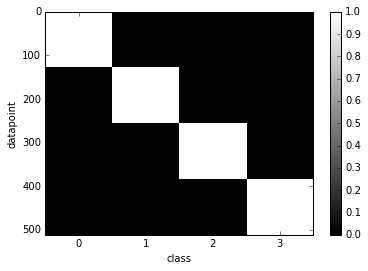

In [3]:
points_per_class = params['batch_size'] / params['input_dim']
labels = np.concatenate([[i] * points_per_class for i in xrange(params['input_dim'])])
np_data = np.eye(params['input_dim'], dtype=np.float32)[labels]
imshow(np_data, interpolation='nearest', aspect='auto', cmap=cm.gray); colorbar()
xticks(range(params['input_dim']))
xlabel('class')
ylabel('datapoint')

## Network definitions

In [4]:
def standard_normal(shape, **kwargs):
    """Create a standard Normal StochasticTensor."""
    return st.StochasticTensor(
        ds.MultivariateNormalDiag(mu=tf.zeros(shape), diag_stdev=tf.ones(shape), **kwargs))

def generative_network(batch_size, latent_dim, input_dim, n_layer, n_hidden, eps=1e-6):
    with tf.variable_scope("generative"):
        z = standard_normal([batch_size, latent_dim], name="p_z")
        h = slim.repeat(z.value(), n_layer, slim.fully_connected, n_hidden, activation_fn=tf.nn.relu)
        # BUG: BernoulliSigmoidP gives NaNs when log_p is large, so we constrain
        # probabilities to be in (eps, 1-eps) and use Bernoulli
        p = eps + (1-2 * eps) * slim.fully_connected(h, input_dim, activation_fn=tf.nn.sigmoid)
        x = st.StochasticTensor(ds.Bernoulli(p=p, name="p_x"))
    return [x, z]

def inference_network(x, latent_dim, n_layer, n_hidden, eps_dim):
    eps = standard_normal([x.get_shape().as_list()[0], eps_dim], name="eps").value()
    h = tf.concat_v2([x, eps], 1)
    with tf.variable_scope("inference"):
        h = slim.repeat(h, n_layer, slim.fully_connected, n_hidden, activation_fn=tf.nn.relu)
        z = slim.fully_connected(h, latent_dim, activation_fn=None, scope="q_z")
    return z

def data_network(x, z, n_layers=2, n_hidden=256, activation_fn=None):
    """Approximate log data density."""
    h = tf.concat_v2([x, z], 1)
    with tf.variable_scope('discriminator'):
        h = slim.repeat(h, n_layers, slim.fully_connected, n_hidden, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

## Construct model and training ops

In [5]:
tf.reset_default_graph()

x = tf.constant(np_data)
p_x, p_z = generative_network(params['batch_size'], params['latent_dim'], params['input_dim'],
                              params['n_layer_gen'], params['n_hidden_gen'])
q_z = inference_network(x, params['latent_dim'], params['n_layer_inf'], params['n_hidden_inf'],
                       params['eps_dim'])

# Discriminator classifies between (x, z_prior) and (x, z_posterior)
# where z_prior ~ p(z), and z_posterior = q(z, eps) with eps ~ N(0, I)
log_d_prior = data_network(x, p_z.value(), n_layers=params['n_layer_disc'],
                           n_hidden=params['n_hidden_disc'])
log_d_posterior = graph_replace(log_d_prior, {p_z.value(): q_z})
disc_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(log_d_posterior, tf.ones_like(log_d_posterior)) +
    tf.nn.sigmoid_cross_entropy_with_logits(log_d_prior, tf.zeros_like(log_d_prior)))

# Compute log p(x|z) with z ~ p(z), used as a placeholder
recon_likelihood_prior = p_x.distribution.log_prob(x)
# Compute log p(x|z) with z = q(x, eps)
# This is the same as the above expression, but with z replaced by a sample from q instead of p
recon_likelihood = tf.reduce_sum(graph_replace(recon_likelihood_prior, {p_z.value(): q_z}), [1])

# Generator tries to maximize reconstruction log-likelihood while minimizing the discriminator output
gen_loss = tf.reduce_mean(log_d_posterior) - tf.reduce_mean(recon_likelihood)

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)#, epsilon=1e-3)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars)

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Train model

In [7]:
from tqdm import tqdm
fs = []
for i in tqdm(xrange(10000)):
    f, _, _ = sess.run([[gen_loss, disc_loss], train_gen_op, train_disc_op])
    fs.append(f)

100%|██████████| 10000/10000 [00:56<00:00, 175.94it/s]


(-3.0, 3.0, -3.5, 3.5)

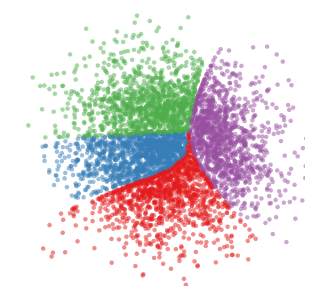

In [9]:
figure(figsize=(5,5), facecolor='w')
n_viz = 10
xx = np.vstack([sess.run(q_z) for _ in range(n_viz)])
ll = np.tile(labels, (n_viz))
scatter(xx[:, 0], xx[:, 1], c=cm.Set1(ll.astype(float)/params['input_dim']/2.0),
        edgecolor='none', alpha=0.5)
xlim(-3, 3); ylim(-3.5, 3.5)
axis('off')